In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import py3dep
from pynhd import NLDI,vector_accumulation
import geopandas as gpd
import pandas as pd
from datetime import datetime

# Grab Aspect data from USGS 3DEP to estimate basin valley orientation.

In [2]:
basins = {
    "east_river_at_almont":"09112500", # billy
    "cement_creek":"09112000", # unknown
    "taylor_river_at_taylor_park":"09107000", # TAPC2 X
    "missouri_creek_near_gold_park":"09063900", # EW6190 
    "gore_creek_at_upper_station":"09065500", # CO160
    "blue_river_near_dillon":"09046600", # E8345
    "stright_creek_below_laskey_gulch_nr_dillon":"09051050",# CO159, CO158
    "animas_river_at_tall_timber_resort_above_tacoma":"09359500", #BBRC2 X
    "cement_creek_at_silverton":"09358550", # CO115 X
    "uncompahgre_river_near_ridgway":"09146200", # CO120
    "dolores_river_below_rico":"09165000" #E6434 X
}
# create a dataframe to store the results
basins_df = pd.DataFrame(columns=["name","geometry"], index=basins.values())
for name, gage_id in basins.items():
    nldi = NLDI()
    basin = nldi.get_basins(gage_id).geometry[0]
    basins_df.loc[gage_id,"name"] = name
    basins_df.loc[gage_id,"geometry"] = basin


/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/geopandas/geoseries.py:628: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/geopandas/geoseries.py:628: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val = getattr(super(), mtd)(*args, **kwargs)
/home/dlhogan/miniforge3/envs/sublime_synoptics/lib/python3.11/site-packages/geopandas/geoseries.py:628: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tr

In [3]:
# reset the index and rename the column gage_id
basins_df = basins_df.reset_index().rename(columns={"index":"gage_id"}) 


In [4]:
def plot_basins(name,
                geometry,
                hillshade, 
                dem,
                aspect_grouped,
                aspect,
                angle,
                ):
    """
        Plot the basin with the DEM, hillshade, aspect histogram, and aspect map.
        Parameters
        ----------
        name : str
                The name of the basin.
        geometry : Polygon
                The geometry of the basin.
        hillshade : xarray.DataArray
                The hillshade of the basin.
        dem : xarray.DataArray
                The DEM of the basin.
        aspect_grouped : xarray.DataArray
                The grouped aspect data.
        aspect : xarray.DataArray
                The aspect data.
        Returns
        -------
        None
    """
    # Create a figure and a GridSpec layout
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[1,1,1,1])

    # Create axes
    ax1 = plt.subplot(gs[0, 1:3])  # Top axes spanning the whole width
    ax2 = plt.subplot(gs[1, 0:2])  # Bottom-left axes
    ax3 = plt.subplot(gs[1, 2:4])  # Bottom-right axes

    # Plot DEM and hillshade
    hillshade.plot(cmap='gray',add_colorbar=False, ax=ax1)
    dem.plot(cmap='terrain', alpha=0.5, ax=ax1)

    # get the centroid of the basin
    centroid = geometry.centroid

    # Plot aspect histogram
    aspect_grouped['aspect_degrees'].plot(ax=ax2)
    # find the midpoint of the max value
    max_idx = aspect_grouped['aspect_degrees'].idxmax().values.tolist().mid
    ax2.axvline(max_idx, ls='--', color='r', label=f'Most Common Aspect: {max_idx:.0f} degrees $\pm 7.5^\degree$')
    ax2.legend()

    # Plot aspect map
    hillshade.plot(cmap='gray',add_colorbar=False, ax=ax3)
    aspect['aspect_degrees'].plot(ax=ax3, cmap='twilight_shifted_r', alpha=0.8)

    # plot a line across the basin following the most common aspect
    x1 = centroid.x
    y1 = centroid.y
    x2 = x1 + np.cos(np.deg2rad(angle) - np.pi/2)
    y2 = y1 + np.sin(np.deg2rad(angle) + np.pi/2)
    x3 = x1 - np.cos(np.deg2rad(angle) - np.pi/2)
    y3 = y1 - np.sin(np.deg2rad(angle) + np.pi/2)


    ax3.plot([x3,x1,x2],
             [y3,y1,y2], 
            color='k', ls='--', lw=3, label='Valley Axis')
    ax3.legend()


    # Customize axes
    ax1.set_title('DEM and Hillshade')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax2.set_title('Aspect Distribution')
    ax2.set_xlabel('Aspect (degrees)')
    ax2.set_ylabel('Count')
    ax3.set_title('Aspect Map')
    ax3.set_xlabel('Longitude')
    ax3.set_ylabel('Latitude')

    ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
    ax3.set_xticklabels(ax3.get_xticks(), rotation=45);

    fig.suptitle(f'{name} Basin', fontsize=16, y=1.02)

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()
    return

In [5]:
geometry = basins_df[basins_df['gage_id']=='09112500'].geometry.values[0]

dem = py3dep.get_dem(geometry, resolution=90, crs=4326)
hillshade = py3dep.get_map("Hillshade Gray", geometry, resolution=90, geo_crs=4326, crs=4326)

In [6]:
# fill na with 0
dem = dem.fillna(0)
# mask out 0 values
dem_ma = np.ma.masked_where(dem.values == 0, dem.values)
hillshade_ma = np.ma.masked_where(dem.values == 0, hillshade.values)

In [7]:
hillshade_ma

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=999999,
  dtype=uint8)

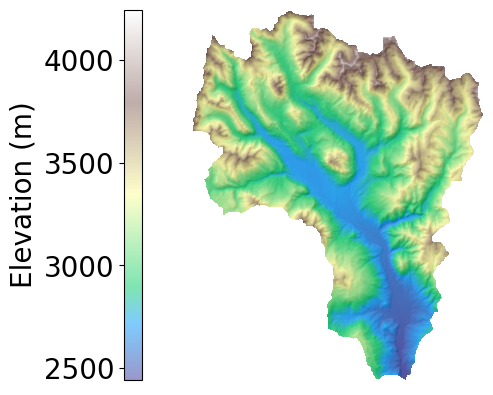

In [14]:
fig, ax = plt.subplots()
# Plot DEM and hillshade
ax.imshow(hillshade_ma, cmap='gray')
# mask nan values in the dem
ax.imshow(dem_ma,cmap='terrain', alpha=0.5,)
# update with no background color
ax.axis('off')
# add a colorbar
cbar = plt.colorbar(ax.imshow(dem_ma,cmap='terrain', alpha=0.5,),
                    # move to left side of the plot
                    ax=ax,
                    orientation='vertical',
                    location='left',
)
cbar.ax.tick_params(labelsize=20)

cbar.set_label('Elevation (m)', size=20)

ax.set_title('')
# update colorbar label
# save figure to file
plt.savefig('../../04_products/figures/sandbox/hillshade_dem.png', bbox_inches='tight', pad_inches=0.1, transparent=True, dpi=300)

In [33]:
# make hypsometric plot with y axis as elevation and x axis as % area
def hypsometric_curve(dem):
    """
        Create a hypsometric curve.
        Parameters
        ----------
        dem : xarray.DataArray
                The DEM of the basin.
        Returns
        -------
        None
    """
    # Calculate the hypsometric curve
    dem_flat = dem.values.flatten()
    dem_flat = dem_flat[~np.isnan(dem_flat)]
    dem_flat = np.sort(dem_flat)
    area = np.linspace(0, 1, len(dem_flat))

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # Plot the hypsometric curve
    ax.plot(dem_flat, area)
    # find the 50th percentiel
    median = np.percentile(dem_flat, 50)
    ax.axvline(median, ls='--', color='r', label=f'Median Elevation: {median:.0f} m')

    # Customize axes
    ax.set_title('Hypsometric Curve')
    ax.set_xlabel('Elevation (m)')
    ax.set_ylabel('Fraction of Area')

    # Show plot
    plt.show()
    return

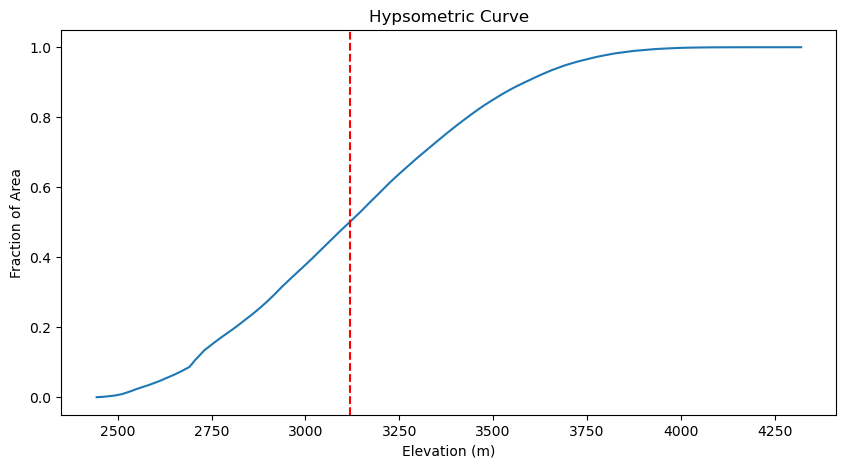

In [34]:
hypsometric_curve(dem)

In [ ]:
# hypsometric plot for east river
def plot_hypsometry(name, dem):
    """
        Plot the hypsometry of the basin.
        Parameters
        ----------
        name : str
                The name of the basin.
        dem : xarray.DataArray
                The DEM of the basin.
        Returns
        -------
        None
    """
    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot hypsometry
    dem.plot.hist(ax=ax, bins=100, color='skyblue', edgecolor='black')
    ax.set_title(f'{name} Hypsometry')
    ax.set_xlabel('Elevation (m)')
    ax.set_ylabel('Frequency')

    # Show plot
    plt.show()
    return

307.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


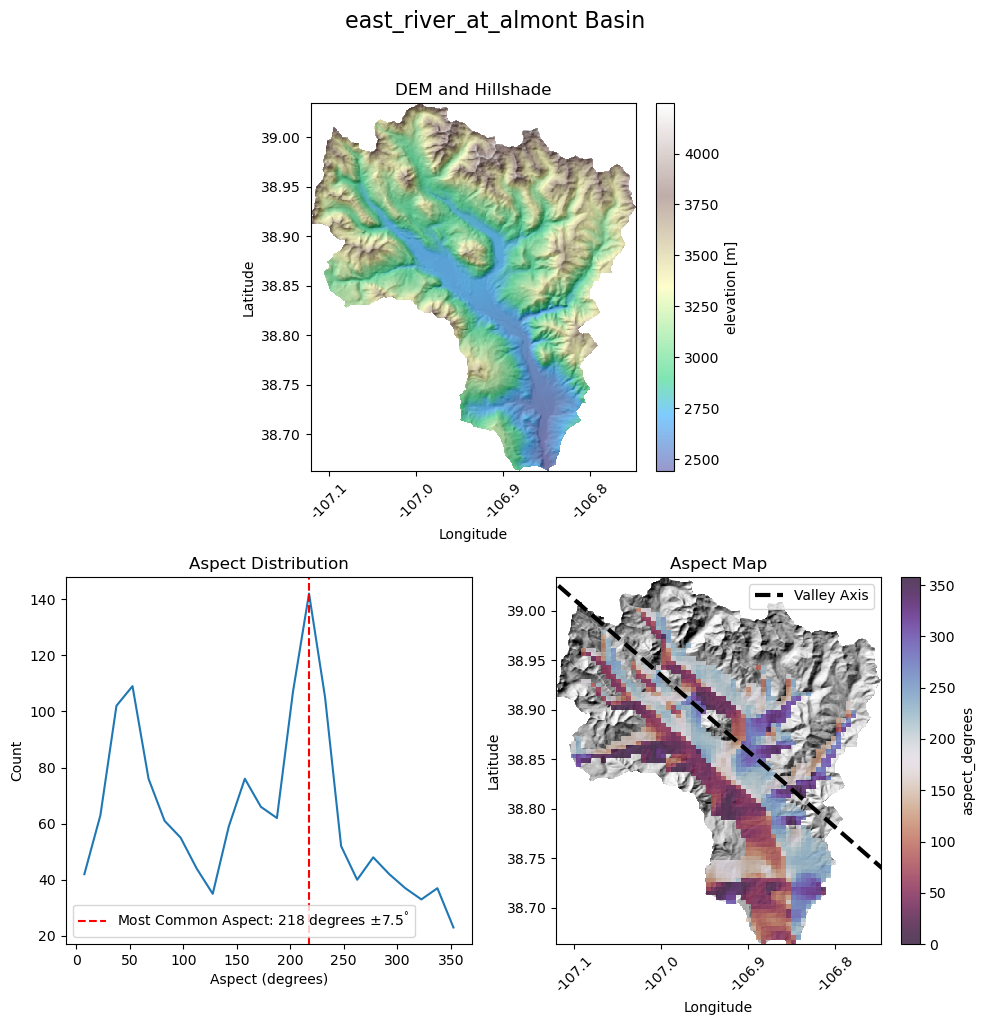

22.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


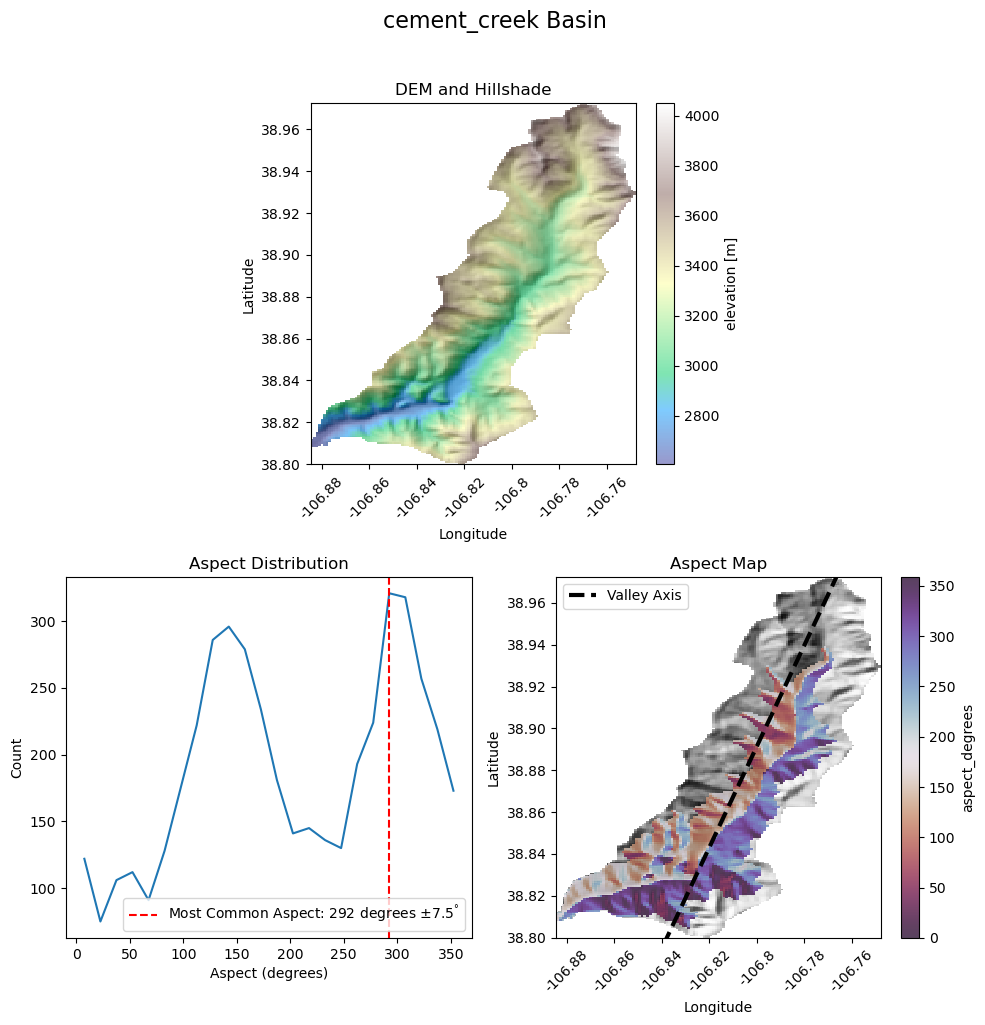

292.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


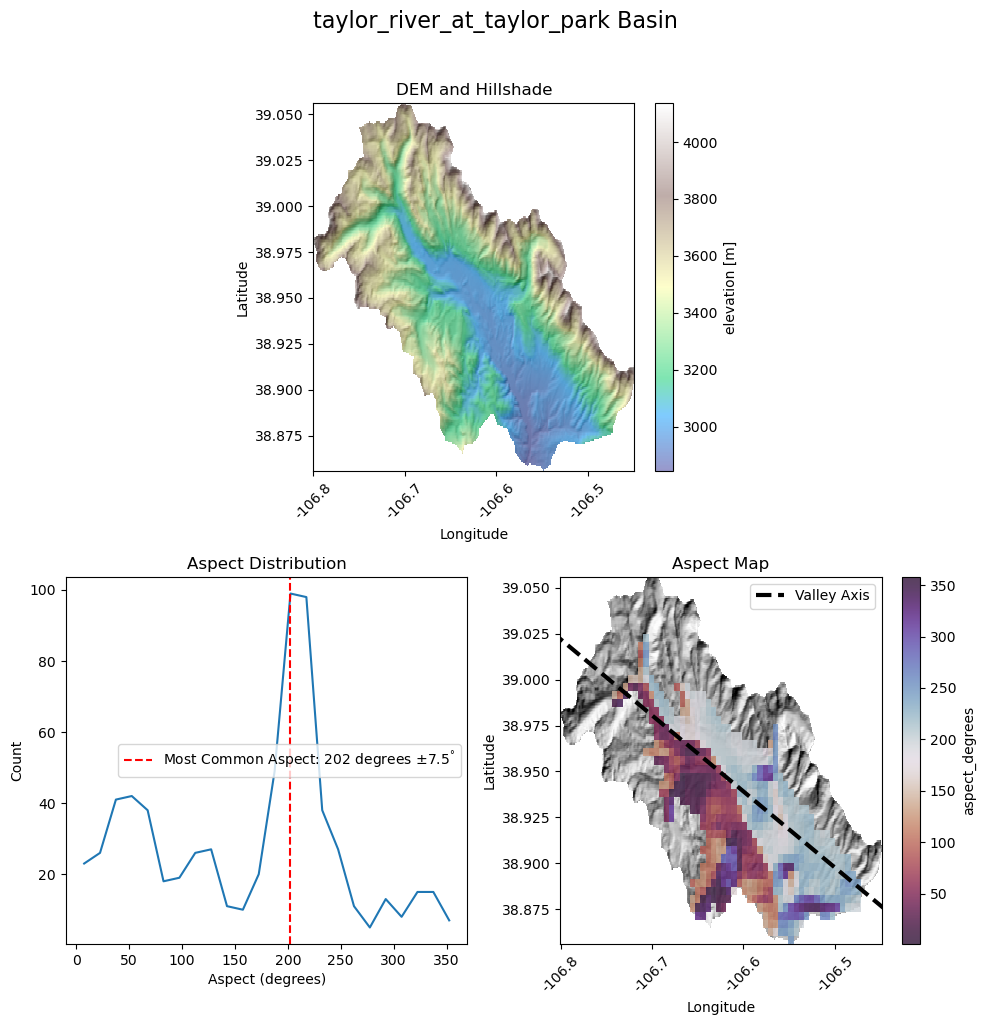

82.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


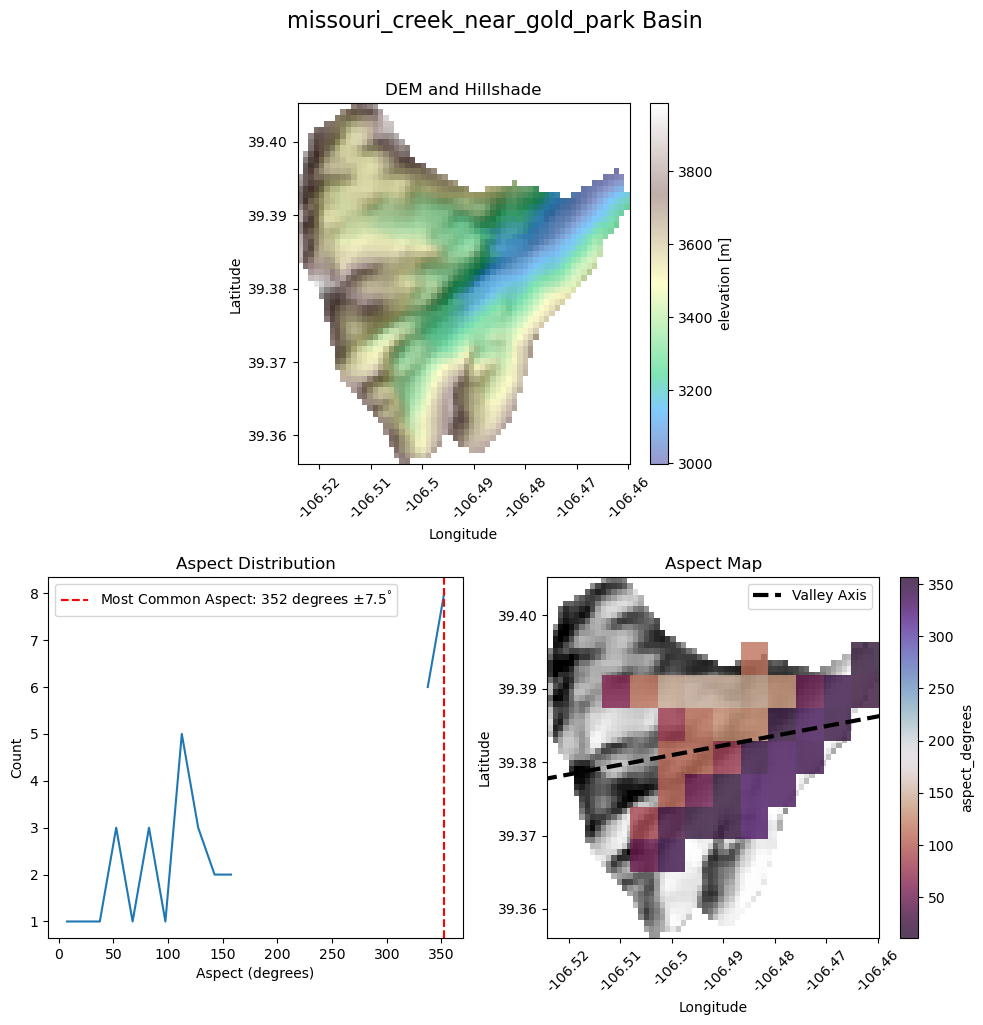

277.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


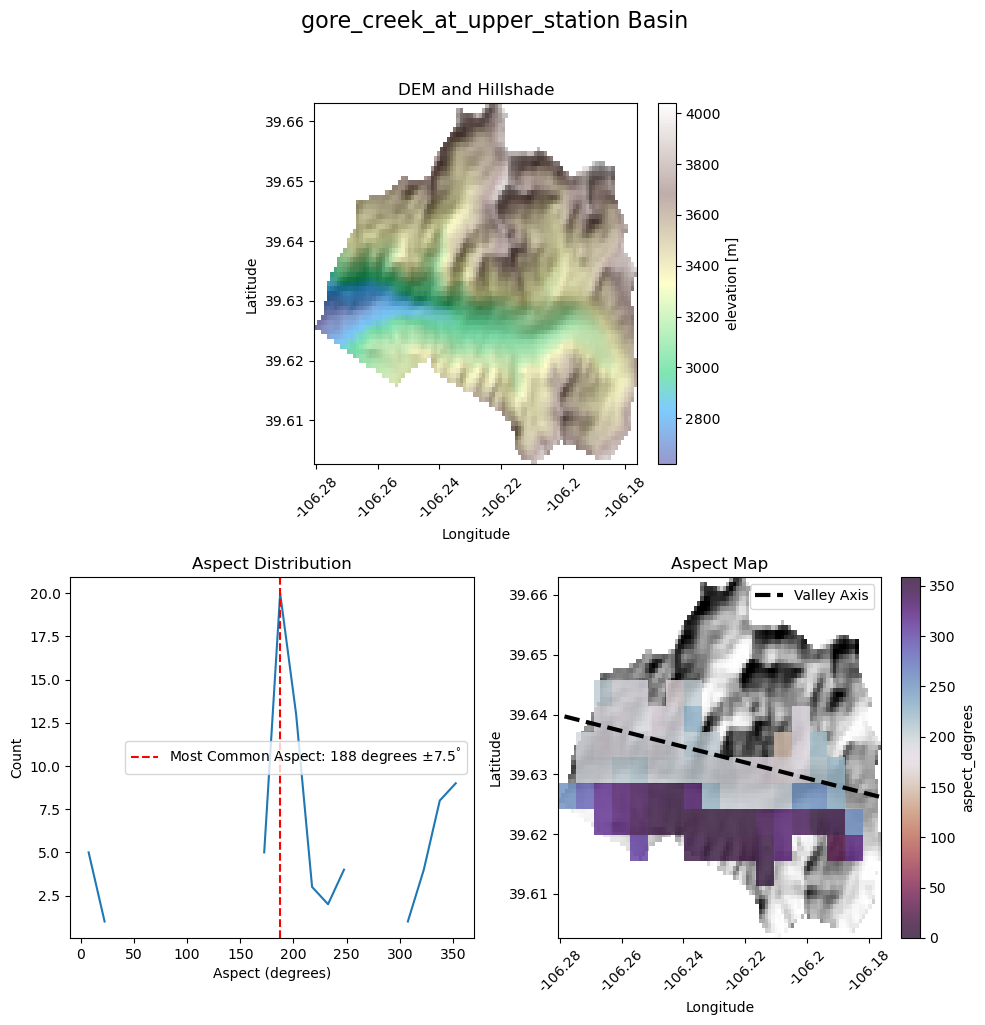

157.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


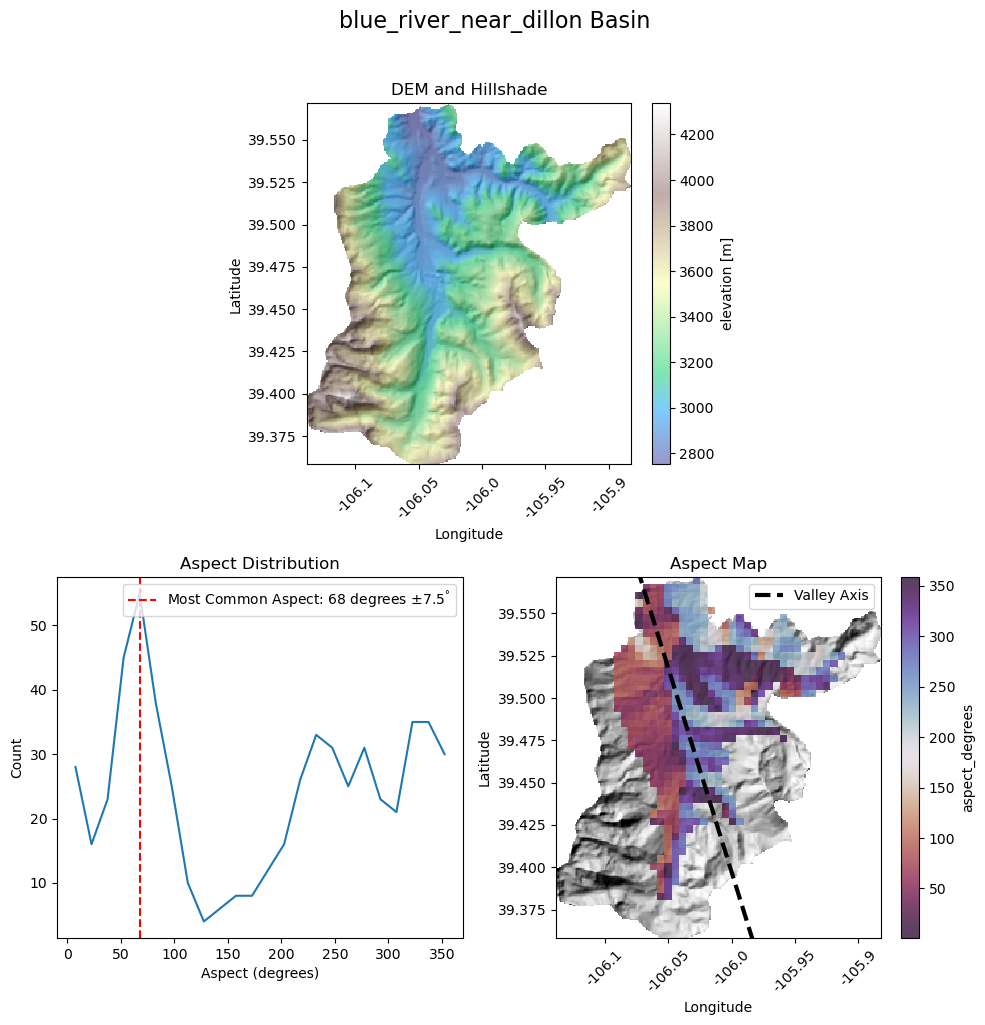

262.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


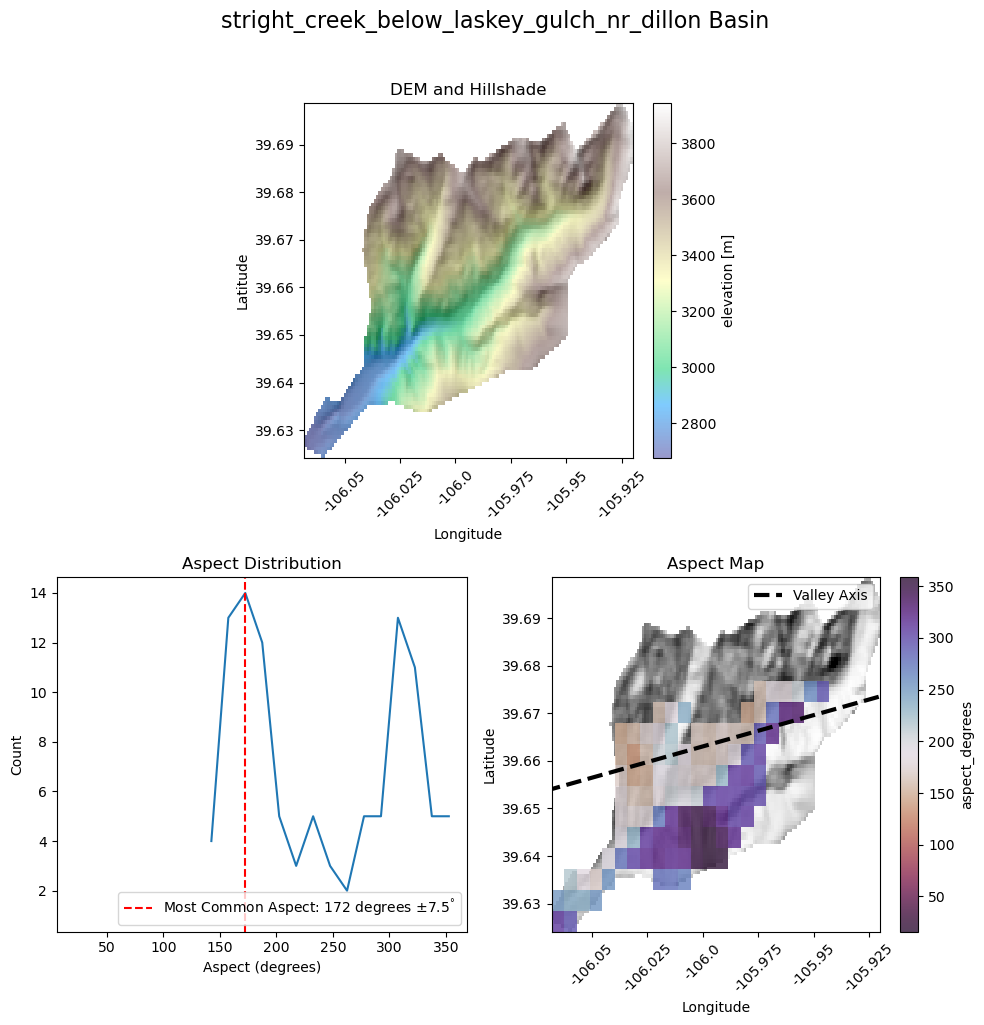

217.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


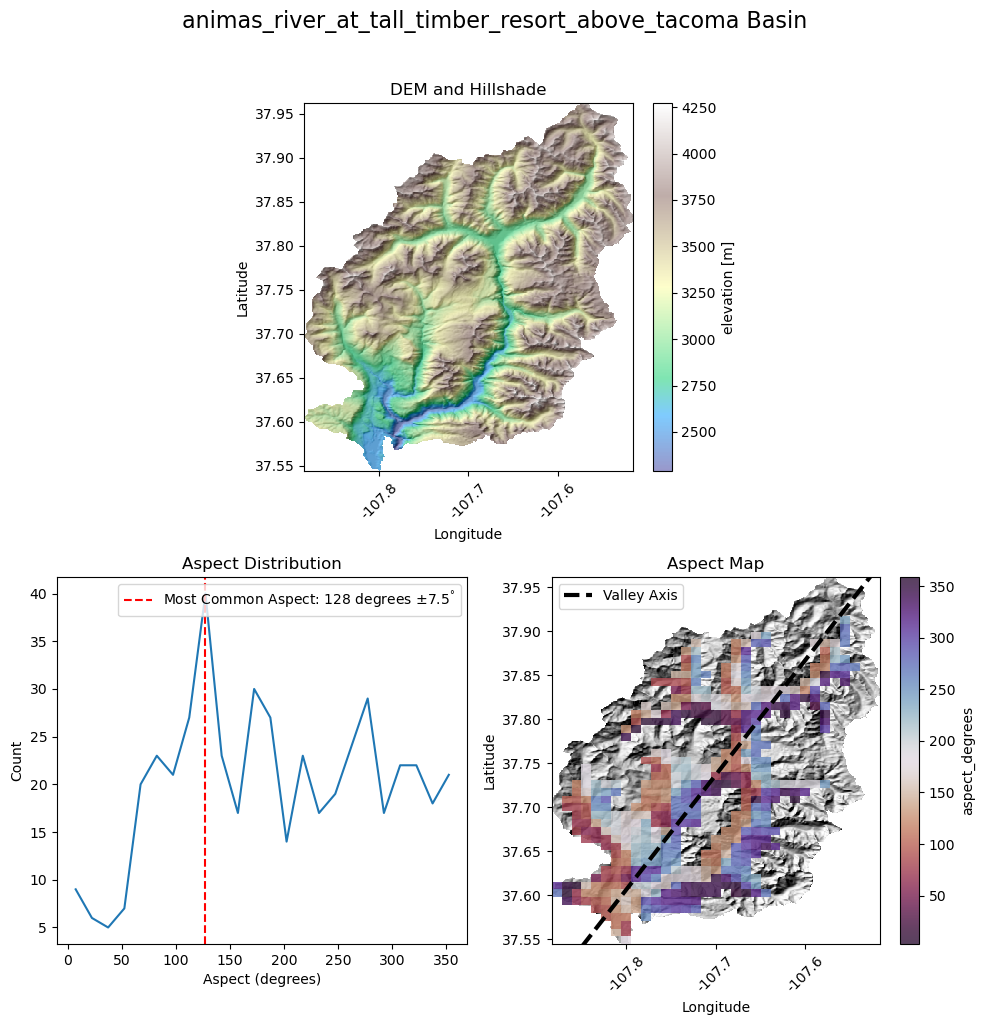

202.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


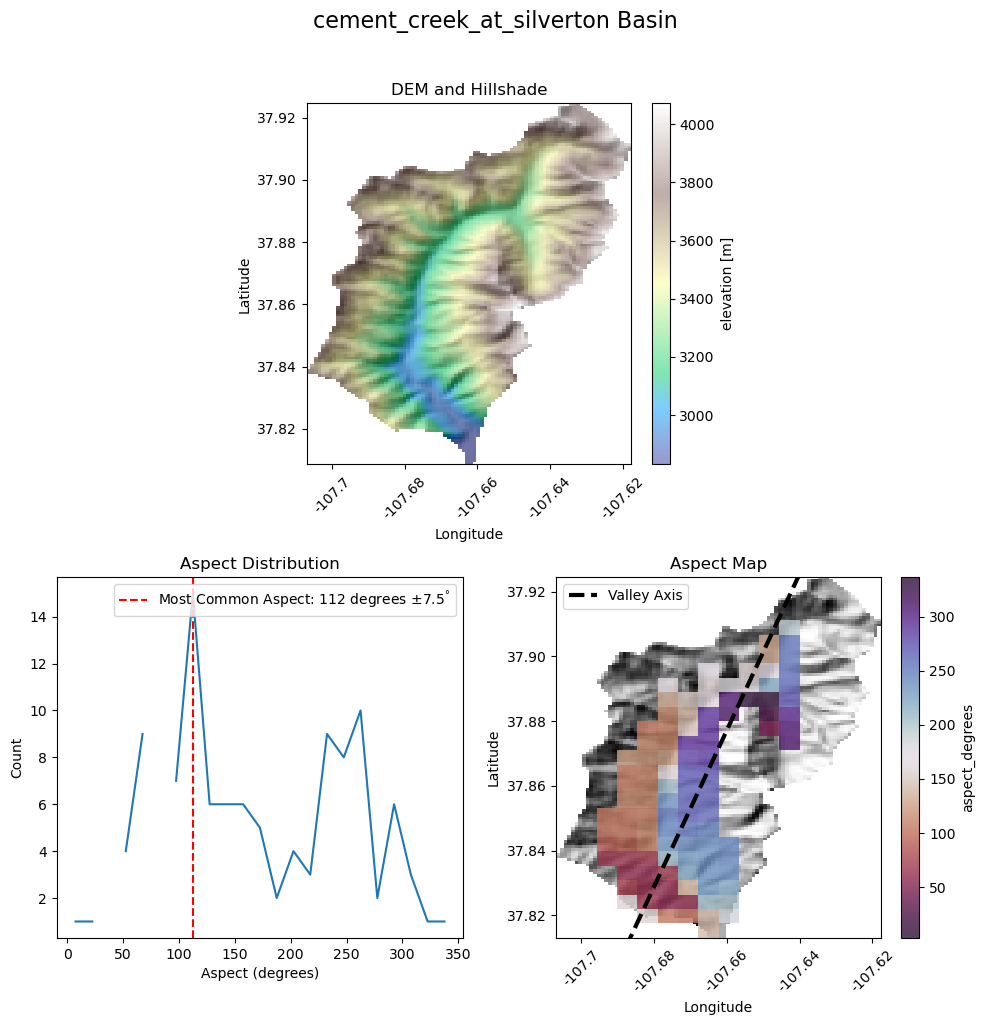

142.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


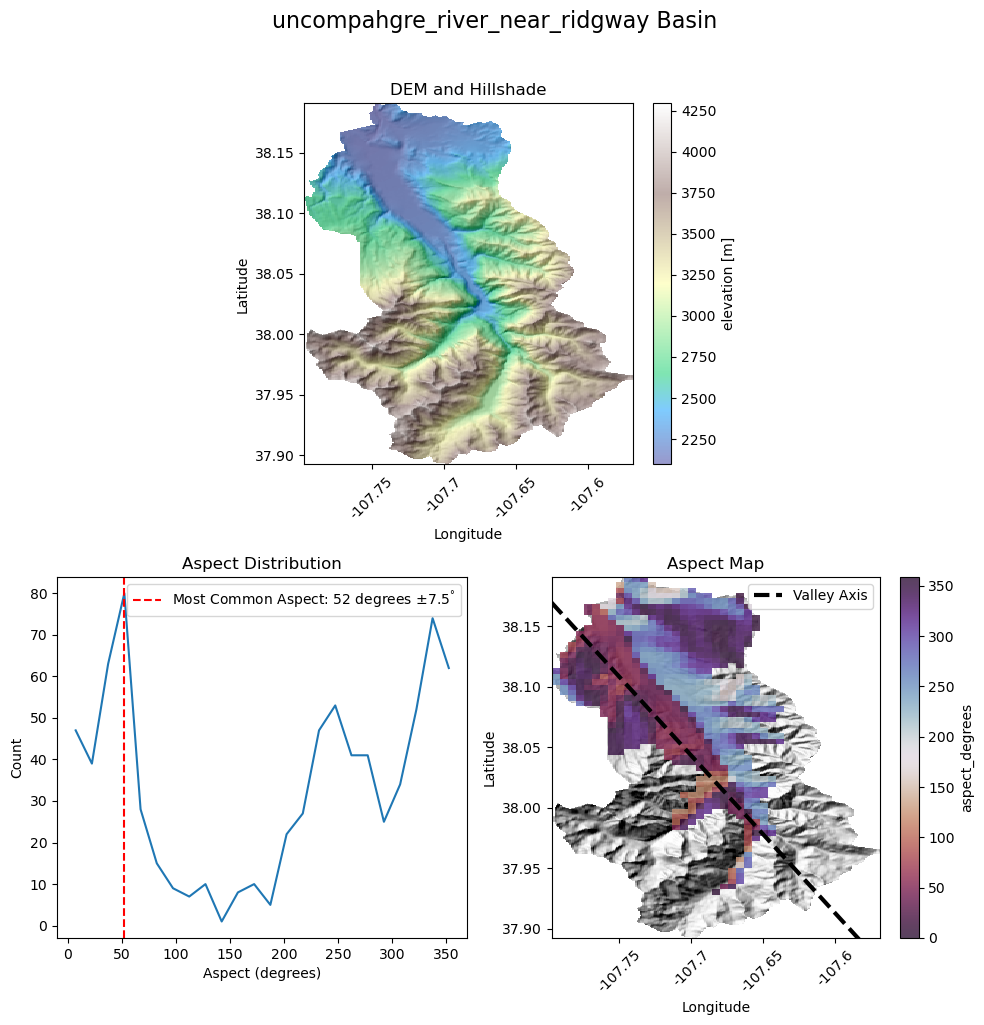

52.5


/tmp/ipykernel_29241/2318608319.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks(), rotation=45);
/tmp/ipykernel_29241/2318608319.py:83: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticks(), rotation=45);


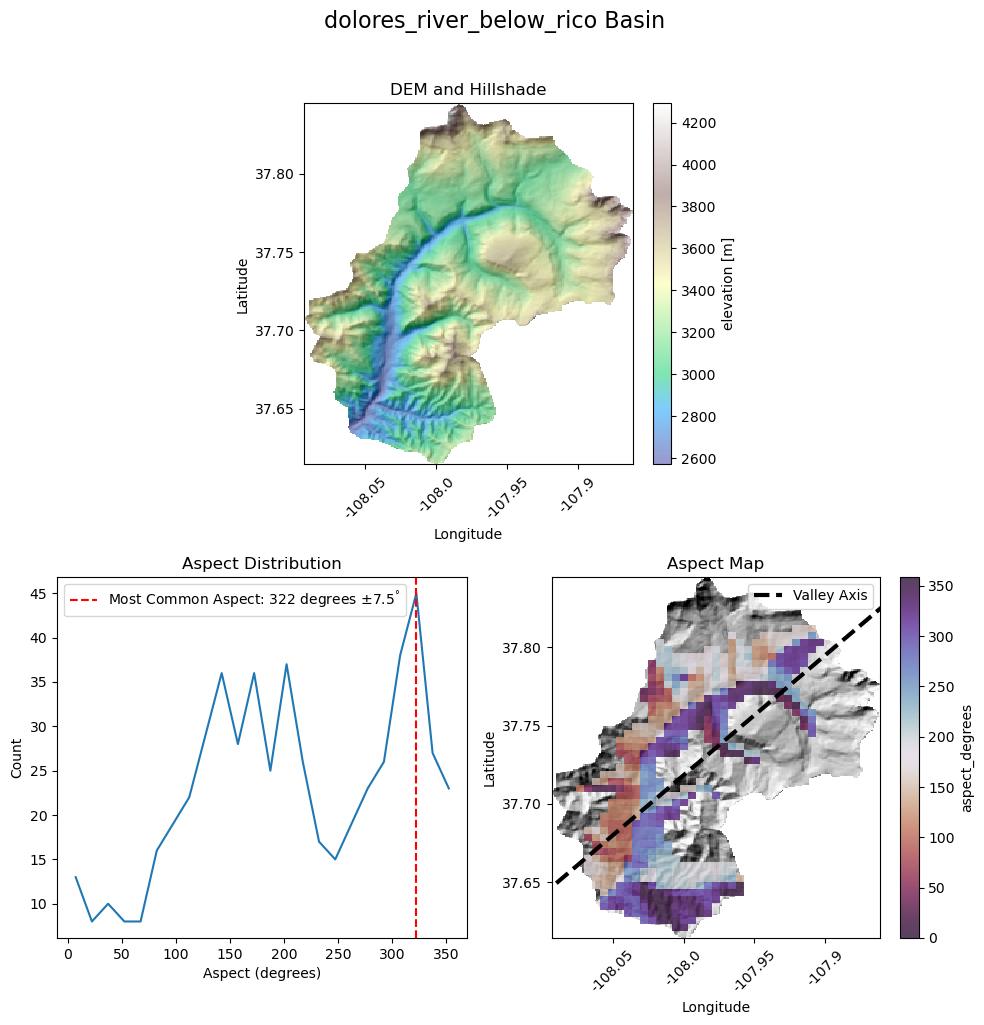

In [191]:
for gage_id in basins_df['gage_id']:
    resolution = 500
    if gage_id in ["09112000","09051050"]:
        resolution = 100
    elif gage_id in ['09359500']:
        resolution=1000
    geometry = basins_df[basins_df['gage_id']==gage_id].geometry.values[0]
    aspect = py3dep.get_map(["DEM", "Aspect Degrees"], geometry, resolution=resolution, geo_crs=4326, crs=4326)
    # add a nan value to the aspect data
    aspect = aspect.where(aspect['aspect_degrees'] <= 360)
    # filter out the highest 50% of data
    threshold = aspect['elevation'].quantile(0.5)
    aspect = aspect.where(aspect['elevation'] < threshold)
    # make a copy of aspect_degrees, called aspect_bins
    aspect['aspect'] = aspect['aspect_degrees']
    dem = py3dep.get_dem(geometry, resolution=90, crs=4326)
    hillshade = py3dep.get_map("Hillshade Gray", geometry, resolution=90, geo_crs=4326, crs=4326)
    # groupby 15 degree bins
    aspect_grouped = aspect.groupby_bins("aspect", np.arange(0, 375, 15)).count()
    # get the mid points of the bins
    mid_points =[aspect_grouped.aspect_bins.values[i].mid for i in range(len(aspect_grouped.aspect_bins.values))]

    # find the midpoint of the max value
    max_idx = aspect_grouped['aspect_degrees'].idxmax().values.tolist().mid

    # calculate the valley orientation
    valley_orientation = max_idx + 90
# if less than 0, add 360
    if valley_orientation < 0:
        valley_orientation += 360
    elif valley_orientation > 360:
        valley_orientation -= 360
    print(valley_orientation)

    # Bin the valley orientation into N, NE, E, SE, S, SW, W, NW
    if valley_orientation < 22.5 or valley_orientation >= 337.5:
        valley_orientation_cardinal = "N"
    elif valley_orientation >= 22.5 and valley_orientation < 67.5:
        valley_orientation_cardinal = "NE"
    elif valley_orientation >= 67.5 and valley_orientation < 112.5:
        valley_orientation_cardinal = "E"
    elif valley_orientation >= 112.5 and valley_orientation < 157.5:
        valley_orientation_cardinal = "SE"
    elif valley_orientation >= 157.5 and valley_orientation < 202.5:
        valley_orientation_cardinal = "S"
    elif valley_orientation >= 202.5 and valley_orientation < 247.5:
        valley_orientation_cardinal = "SW"
    elif valley_orientation >= 247.5 and valley_orientation < 292.5:
        valley_orientation_cardinal = "W"
    else:
        valley_orientation_cardinal = "NW"
    # add the valley orientation and cardinal direction to the dataframe
    basins_df.loc[basins_df['gage_id']==gage_id,"valley_orientation"] = valley_orientation
    basins_df.loc[basins_df['gage_id']==gage_id,"valley_orientation_cardinal"] = valley_orientation_cardinal
    # plot the basin
    plot_basins(basins_df[basins_df['gage_id']==gage_id].name.values[0],
            geometry,
            hillshade, 
            dem,
            aspect_grouped,
            aspect, 
            valley_orientation)

In [198]:
# convert to a geoDataFrame
gdf = gpd.GeoDataFrame(basins_df, geometry='geometry')

In [199]:
gdf.to_file("../../01_data/processed_data/valley_orinetation_basins.geojson")